In [189]:
#Data handling visualizing and Machine Learning
import numpy as np
import pandas as pd
import warnings
import itertools
import statsmodels
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics

#Utilities
import datetime
import random # used for random grid searching 
from dateutil import parser #used for parsing datetime columns
from IPython.display import display
from IPython.display import Image #used for displaying images
import math

print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('statsmodels version:', statsmodels.__version__)
print('matplotlib version:', matplotlib.__version__)

%matplotlib inline

numpy version: 1.20.3
pandas version: 1.3.4
statsmodels version: 0.12.2
matplotlib version: 3.4.3


In [124]:
#This data only includes journeys with Schiphol Airport as end destination in January
df = pd.read_csv('January_Schiphol_Time_Groups.csv')
df.shape

(76315, 16)

In [125]:
df = df.drop(columns = ["Unnamed: 0", "Train_Departure_Planned_Time"])

Time_Group is a category that indicates which part of the day the specific train on that row planned to depart, it can have 5 different values:
- 1 Early_Morning        (00:00 - 05:59)
- 2 Morning_Rush_Hour    (06:00 - 09:59)
- 3 Between_Rush_hours   (10:00 - 14:59)
- 4 Afternoon_Rush_hour  (15:00 - 18:59)
- 5 Night                (19:00 - 24:00)

In [126]:
#I add a time group number
df["Time_Group_Number"] = np.where(df['Time_Group'] == 'Early_Morning', 1,
                          np.where(df['Time_Group'] == 'Morning_Rush_Hour', 2,
                          np.where(df['Time_Group'] == 'Between_Rush_hours', 3,
                          np.where(df['Time_Group'] == 'Afternoon_Rush_hour', 4,
                          np.where(df['Time_Group'] == 'Night', 5, 0)))))

In [127]:
df['Train_Departure_Actual'] = df.apply(lambda row: parser.parse(row.Train_Departure_Actual), axis=1)
df['Train_Departure_Planned'] = df.apply(lambda row: parser.parse(row.Train_Departure_Planned), axis=1)
df["day_of_week"] = df["day_of_week"].astype("category")
df["Time_Group"] = df["Time_Group"].astype("category")
df["Train_Type"] = df["Train_Type"].astype("category")
df.dtypes

Station_Code                         object
Station_Name                         object
Train_Number                          int64
Train_Type                         category
Train_Company                        object
Train_Destination_Planned            object
Train_Destination_Actual             object
Train_Departure_Planned      datetime64[ns]
Train_Departure_Actual       datetime64[ns]
Train_Delay                         float64
MaxNumberOfStops                      int64
weekday                               int64
day_of_week                        category
Time_Group                         category
Time_Group_Number                     int32
dtype: object

In [128]:
df.set_index('Train_Departure_Planned', inplace=True)
df

,Station_Code,Station_Name,Train_Number,Train_Type,Train_Company,Train_Destination_Planned,Train_Destination_Actual,Train_Departure_Actual,Train_Delay,MaxNumberOfStops,weekday,day_of_week,Time_Group,Time_Group_Number
Train_Departure_Planned,,,,,,,,,,,,,,
2016-01-01 06:44:00,HRL,Heerlen,3528,Intercity,NS,Schiphol Airport,Schiphol Airport,2016-01-01 06:44:00,0.0,10,4,Friday,Morning_Rush_Hour,2
2016-01-01 06:48:00,EHV,Eindhoven,3524,Intercity,NS,Schiphol Airport,Schiphol Airport,2016-01-01 06:48:00,0.0,10,4,Friday,Morning_Rush_Hour,2
2016-01-01 07:00:00,STD,Sittard,3528,Intercity,NS,Schiphol Airport,Schiphol Airport,2016-01-01 07:00:00,0.0,10,4,Friday,Morning_Rush_Hour,2
2016-01-01 07:02:00,DV,Deventer,1624,Intercity,NS,Schiphol Airport,Schiphol Airport,2016-01-01 07:02:00,0.0,10,4,Friday,Morning_Rush_Hour,2
2016-01-01 07:09:00,HT,'s-Hertogenbosch,3524,Intercity,NS,Schiphol Airport,Schiphol Airport,2016-01-01 07:09:00,0.0,10,4,Friday,Morning_Rush_Hour,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-01-31 22:53:00,HVS,Hilversum,1684,Intercity,NS,Schiphol Airport,Schiphol Airport,2016-01-31 22:53:00,0.0,13,6,Sunday,Night,5
2016-01-31 23:10:00,AMF,Amersfoort,11686,Intercity,NS,Schiphol Airport,Schiphol Airport,2016-01-31 23:10:00,0.0,6,6,Sunday,Night,5
2016-01-31 23:40:00,DVD,Duivendrecht,11686,Intercity,NS,Schiphol Airport,Schiphol Airport,2016-01-31 23:40:00,0.0,6,6,Sunday,Night,5


In [129]:
#Here I remove previously found negative delays.
#I change them into 0
df.loc[df.Train_Delay < 0, 'Train_Delay'] = 0

I'll start by creating a column that makes a consecutive timegroup sum

Since there are 5 time groups per day and 31 days in january, Time_Group_Day will go from 1 to 155(31*5). This is of course also extendable to 
(e.g. 1 represents Early_Morning day one of January)
(e.g. 5 represents Night of day one of January
- 1 Early_Morning        (00:00 - 05:59)
- 2 Morning_Rush_Hour    (06:00 - 09:59)
- 3 Between_Rush_hours   (10:00 - 14:59)
- 4 Afternoon_Rush_hour  (15:00 - 18:59)
- 5 Night                (19:00 - 24:00)

I might be able to do this using a more cookbook method using numpy's clipping function
Here I found a helpful solution I will investigate further
(https://stackoverflow.com/questions/15408156/resampling-with-custom-periods)
No absolutely not this will take too long. There is a better way to do this that is more useful to learn but it will take ages to learn

In [130]:
df['Time_Group_Day'] = df['Time_Group_Number'] + (df.index.day - df.index.day.min())*5

In [131]:
#Early morning but it's february
df.loc[df['Time_Group_Day'] == 1]

,Station_Code,Station_Name,Train_Number,Train_Type,Train_Company,Train_Destination_Planned,Train_Destination_Actual,Train_Departure_Actual,Train_Delay,MaxNumberOfStops,weekday,day_of_week,Time_Group,Time_Group_Number,Time_Group_Day
Train_Departure_Planned,,,,,,,,,,,,,,,
2016-02-01 00:02:00,RTD,Rotterdam Centraal,1406,Intercity,NS,Schiphol Airport,Schiphol Airport,2016-02-01 00:02:00,0.0,2,0,Monday,Early_Morning,1,1


As you can see above the train which departs in early morning on day 1 of the month is actually departing in feburary and so should actually be after the last day of January.
Let's change it to 156 manually bthen since it's chronologically after 155

In [132]:
df.loc[df.Time_Group_Day == 1, 'Time_Group_Day'] = 156

In [133]:
dftiny = df[['Train_Delay', 'Time_Group_Number', 'Time_Group_Day']]

In [134]:
dftiny

,Train_Delay,Time_Group_Number,Time_Group_Day
Train_Departure_Planned,,,
2016-01-01 06:44:00,0.0,2,2
2016-01-01 06:48:00,0.0,2,2
2016-01-01 07:00:00,0.0,2,2
2016-01-01 07:02:00,0.0,2,2
2016-01-01 07:09:00,0.0,2,2
...,...,...,...
2016-01-31 22:53:00,0.0,5,155
2016-01-31 23:10:00,0.0,5,155
2016-01-31 23:40:00,0.0,5,155


In [135]:
pd.unique(dftiny.Time_Group_Day)

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156],
      dtype=int64)

*Morning Rush hour* of January 1st is time group 2

.
.
.
.

*Early Morning* of February 1st is time group 156

In [136]:
dftiny['Train_Departure_Planned'] = dftiny.index

In [137]:
#Here I want to group train departures by the part of the day they departed in.

#However I want to do different things with each column
#I want to get the average delay
#but I want the median time as that time's the closest to all departures

#After this attempt I want to use Alex's clustering to define more accurate time groups  
#this will help sarimax take rush hours into account
grouped = dftiny.groupby(['Time_Group_Day'], as_index=False)
grouped

In [138]:
#I get the median time per time group
grouped_time = grouped['Train_Departure_Planned'].median()

In [139]:
#I calculate average delay per time group
grouped_delay = grouped['Train_Delay'].mean()

In [140]:
dfGroupie = grouped_time.merge(grouped_delay)

In [141]:
dfGroupie.drop(columns='Time_Group_Day', inplace=True)

In [142]:
dfGroupie.set_index('Train_Departure_Planned', inplace=True)

In [143]:
dfGroupie.drop(index='2016-02-01 00:02:00', inplace=True)
dfGroupie

,Train_Delay
Train_Departure_Planned,
2016-01-01 08:36:00,58.196078
2016-01-01 12:27:00,15.819193
2016-01-01 16:53:00,33.414191
2016-01-01 20:40:00,128.553425
2016-01-02 04:41:00,49.087719
...,...
2016-01-31 04:27:00,31.684211
2016-01-31 08:30:00,56.927326
2016-01-31 12:42:30,58.666667


HAHA!
now I have an average delay by time group and I can make this time group is customizable. 
So I can later change the time groups to better fit rush hour timing.

First let's see if it actually helps with predicting delay better

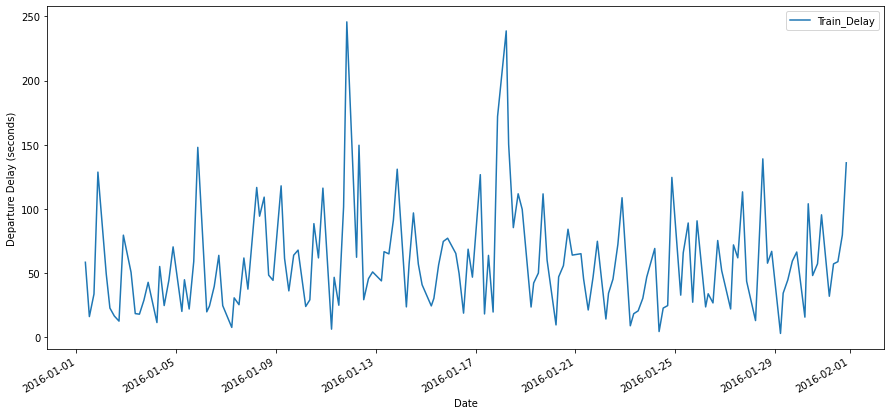

In [84]:
#154 rows for nearly every time group from January
ax = dfGroupie.plot(figsize=(15,7))
ax.set_xlabel('Date')
ax.set_ylabel('Departure Delay (seconds)')
plt.show()

In [85]:
dfGroupie.describe()

,Train_Delay
count,154.000000
mean,58.430715
std,41.159437
min,2.669291
25%,26.613740
50%,50.088431
75%,72.106210
max,245.764957


## GRID SEARCHING SETUP

## Seasonality component
Below you can see I feed 3 differnt pdq values along with a '5' into the seasonal_pdq variable.
The 5 represents the seasonality component I want to feed the SARIMAX algorithm.
Specifically I chose 5 because we sliced each day into 5 parts related to rush hours:
- 1 Early_Morning        (00:00 - 05:59)
- 2 Morning_Rush_Hour    (06:00 - 09:59)
- 3 Between_Rush_hours   (10:00 - 14:59)
- 4 Afternoon_Rush_hour  (15:00 - 18:59)
- 5 Night                (19:00 - 24:00)

With this I can (for example) compare early morning train delays with other early morning train delays.
In the end the algorithm will try to find patterns there and attempt to forecast delay duration based on these patterns

**S**ARIMA**X** uses **S**easonality and e**X**ogenous features which ARIMA does not. With patterns like weekdays and rush hours probably having a high impact in train delays it is best if we use SARIMAX.

## Hyperparameter Selection

### Setup

The very best parameters found so far are SARIMAX(4, 7, 4)x(0, 7, 6)5 with a ridiculous score of AIC:30

In [86]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

# Due to rush hours slicing each day in 5 and data being aggregated into those slices
# I want to compare for example monday morning to tuesday morning to wednesday morning
seasonality = 5

# The inner loop will generate hyperparameter combinations and fit them this many times
iterations = 20

# I will do the above loop this many times, each time storing the best one of the batch in top_scores
# In the end I will have the top 'best' scores
best = 5

print("I will generate and fit hyperparameters in batches of {}, choosing the best one {} times, using a seasonality of {}\nSARIMAX will be fitted {} times in total.".format(iterations, best, seasonality, iterations*best))

I will generate and fit hyperparameters in batches of 20, choosing the best one 5 times, using a seasonality of 5
SARIMAX will be fitted 100 times in total.


In [87]:
# This stores every single result from all batches
all_results = []

# This contains the best (lowest) score parameters, if everything goes right top_scores will have a length of best
top_scores = []

# This counts the number of times the fitting process didn't complete due to an exception
exceptions = 0

# Outer loop, runs 'best' number of times to get the best paramaters from a given batch
for i in range(best):
    
    # batch_of_results is python list of lists
    # batch_of_results contains iterations number of arrays inside, each of those arrays has 3 elements
    # those 3 elements are [pdq paramereters, seasonal pdq parameters, their score after fitting]
    batch_of_results = []
    
    # Inner loop, runs 'iterations' number of times
    # Generates parameters randomly and fits them
    for j in range(iterations):
        print('Batch {} of {} - Iteration {} of {}'.format(i, best-1, j, iterations-1))
        # HYPERPARAMETER GENERATION
        # I generate each of the hyper parameters randomly between 0 and 6 inclusive
        # Using random parameters might lead to nonsensical algorithms which would lead to longer processing or weird scores
        p = random.randint(0, 6)
        d = random.randint(0, 6)
        q = random.randint(0, 6)

        seasonal_p = random.randint(0, 6)
        seasonal_d = random.randint(0, 6)
        seasonal_q = random.randint(0, 6)
        
        print('SARIMAX{}x{}{} - AIC:'.format((p, d, q), (seasonal_p, seasonal_d, seasonal_q), seasonality), end ='')
        try:
            mod = sm.tsa.statespace.SARIMAX(dfGroupie,
                                            order = (p, d, q),
                                            seasonal_order = (seasonal_p, seasonal_d, seasonal_q, seasonality),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            # Fit model to data according to hyperparameters defined in mod and store result
            results = mod.fit()

            # store the score in all score array
            batch_of_results.append(((p, d, q), (seasonal_p, seasonal_d, seasonal_q, seasonality), results))
            all_results.append(((p, d, q), (seasonal_p, seasonal_d, seasonal_q, seasonality), results))


            print('{}'.format(results.aic))
        except:
            print('exception')
            exceptions = exceptions + 1
            continue
    
    # Below I extract the best scores
    # I do this by sorting the third element (score) of the batch_of_results array because the first 2 elements are the parameters
    # sorted() then just sorts the batch_of_results array by score
    # finally I slice it and get the very best score (it's the lowest so it's the first one after sorting)
    top_scores.append(sorted(batch_of_results, key = lambda x: (x[2]).aic)[:1])

Batch 0 of 4 - Iteration 0 of 19
SARIMAX(2, 5, 0)x(6, 3, 1)5 - AIC:1590.2320938821438
Batch 0 of 4 - Iteration 1 of 19
SARIMAX(5, 5, 6)x(6, 4, 5)5 - AIC:exception
Batch 0 of 4 - Iteration 2 of 19
SARIMAX(2, 4, 0)x(5, 6, 4)5 - AIC:2110.894525519655
Batch 0 of 4 - Iteration 3 of 19
SARIMAX(4, 5, 5)x(0, 2, 4)5 - AIC:exception
Batch 0 of 4 - Iteration 4 of 19
SARIMAX(0, 4, 6)x(2, 3, 3)5 - AIC:exception
Batch 0 of 4 - Iteration 5 of 19
SARIMAX(6, 6, 0)x(3, 3, 6)5 - AIC:exception
Batch 0 of 4 - Iteration 6 of 19
SARIMAX(1, 4, 2)x(6, 6, 2)5 - AIC:1940.4039387692528
Batch 0 of 4 - Iteration 7 of 19
SARIMAX(6, 0, 6)x(6, 3, 2)5 - AIC:exception
Batch 0 of 4 - Iteration 8 of 19
SARIMAX(4, 6, 0)x(4, 1, 4)5 - AIC:1623.2239060971885
Batch 0 of 4 - Iteration 9 of 19
SARIMAX(3, 2, 4)x(5, 2, 3)5 - AIC:1309.7316820585063
Batch 0 of 4 - Iteration 10 of 19
SARIMAX(3, 5, 3)x(6, 0, 0)5 - AIC:1391.8048698311338
Batch 0 of 4 - Iteration 11 of 19
SARIMAX(4, 5, 1)x(3, 2, 1)5 - AIC:1490.3002272784338
Batch 0 of 4

SARIMAX(5, 5, 3)x(0, 4, 2)5 - AIC:1894.0984096571517


In [88]:
print("Generated parameters were discarded due to an exception {} times out of the planned {}".format(exceptions, iterations*best))

Generated parameters were discarded due to an exception 44 times out of the planned 100


In [89]:
p = 4
d = 6
q = 4
s_p = 1
s_d = 6
s_q = 6
mod = sm.tsa.statespace.SARIMAX(dfGroupie,
                                            order = (p, d, q),
                                            seasonal_order = (s_p, s_d, s_q, seasonality),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

# Fit model to data according to hyperparameters defined in mod and store result

params = [((p, d, q), (s_p, s_d, s_q, 5), results)]
results = mod.fit()
top_scores.append(params)

# 
p = 4
d = 7
q = 4
s_p = 0
s_d = 7
s_q = 6
mod = sm.tsa.statespace.SARIMAX(dfGroupie,
                                            order = (p, d, q),
                                            seasonal_order = (s_p, s_d, s_q, seasonality),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

# Fit model to data according to hyperparameters defined in mod and store result

params = [((p, d, q), (s_p, s_d, s_q, 5), results)]
results = mod.fit()
top_scores.append(params)

In [90]:
for score_array in top_scores:
    score = score_array[0]
    print('SARIMAX{}x{} - AIC: {}'.format(score[0], score[1], (score[2]).aic))

SARIMAX(2, 2, 2)x(0, 2, 5, 5) - AIC: 1253.9777039938854
SARIMAX(1, 0, 3)x(6, 1, 3, 5) - AIC: 1227.2906164096896
SARIMAX(4, 1, 4)x(1, 2, 6, 5) - AIC: 1183.469633352571
SARIMAX(2, 0, 1)x(2, 1, 0, 5) - AIC: 1446.4203960390919
SARIMAX(0, 0, 2)x(6, 2, 2, 5) - AIC: 1209.6109948254264
SARIMAX(4, 6, 4)x(1, 6, 6, 5) - AIC: 1894.0984096571517
SARIMAX(4, 7, 4)x(0, 7, 6, 5) - AIC: 32.0


Above I've extracted the five best scores and stored them in top_scores

To try to improve these already good scores I've defined a function below called apply_small_changes()

It takes a python list of scores and makes small changes to the parameters to try to find better parameters.

I specifically chose to make a function because I noticed this process was almost indefinitely repeatable. 
Every time I used it I would find slightly better hyperparameters

In [91]:
def apply_small_changes(scores):
    exceptions = 0
    new_results = []

    # Possible changes for hyperparameters, chosen randomly
    small_changes = [-1, 0, 0, 0, 1]

    # For each of the top scores make small changes and see if they improve
    for score_array in scores:
        score = score_array[0]
        print('ORIGINAL {}x{}{} - AIC:{}'.format(score[0], score[1], seasonality, score[2].aic))

        # make small changes to create new parameters 5 times
        for j in range(5):
            
            # Randomly choose a number from the small changes array and add it to each parameter
            p = (score[0][0] + random.choice(small_changes))
            d = (score[0][1] + random.choice(small_changes))
            q = (score[0][2] + random.choice(small_changes))

            seasonal_p = (score[1][0] + random.choice(small_changes))
            seasonal_d = (score[1][1] + random.choice(small_changes))
            seasonal_q = (score[1][2] + random.choice(small_changes))

            print('SARIMAX{}x{}{} - AIC:'.format((p, d, q), (seasonal_p, seasonal_d, seasonal_q), seasonality), end ='')

            # Test them
            try:
                mod = sm.tsa.statespace.SARIMAX(dfGroupie,
                                                order = (p, d, q),
                                                seasonal_order = (seasonal_p, seasonal_d, seasonal_q, seasonality),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                # Fit model to data according to hyperparameters defined in mod and store result
                results = mod.fit()

                # store the score in all score array
                new_results.append([(p, d, q), (seasonal_p, seasonal_d, seasonal_q, seasonality), results])


                print('{}'.format(results.aic))
            except:
                print('exception')
                exceptions = exceptions + 1
                continue
    print("Changed parameters were discarded due to an exception {} times of the planned {}".format(exceptions, len(scores)*5))
    return(new_results)

In [92]:
new_results = apply_small_changes(top_scores)

ORIGINAL (2, 2, 2)x(0, 2, 5, 5)5 - AIC:1253.9777039938854
SARIMAX(3, 2, 2)x(0, 2, 5)5 - AIC:1327.0226386967697
SARIMAX(2, 2, 2)x(1, 2, 6)5 - AIC:1198.3155189680529
SARIMAX(1, 3, 2)x(1, 2, 5)5 - AIC:1319.2373465959404
SARIMAX(3, 2, 1)x(0, 3, 5)5 - AIC:1290.4104278330049
SARIMAX(1, 3, 2)x(0, 2, 6)5 - AIC:1359.0271002538248
ORIGINAL (1, 0, 3)x(6, 1, 3, 5)5 - AIC:1227.2906164096896
SARIMAX(1, 0, 3)x(6, 2, 2)5 - AIC:1243.651291379003
SARIMAX(1, 0, 3)x(6, 1, 3)5 - AIC:1227.2906164096896
SARIMAX(0, 0, 3)x(6, 1, 4)5 - AIC:1232.6230462546916
SARIMAX(1, 0, 3)x(5, 0, 3)5 - AIC:1337.3255392792576
SARIMAX(0, -1, 4)x(6, 1, 3)5 - AIC:exception
ORIGINAL (4, 1, 4)x(1, 2, 6, 5)5 - AIC:1183.469633352571
SARIMAX(5, 2, 5)x(2, 2, 6)5 - AIC:exception
SARIMAX(5, 1, 4)x(0, 3, 6)5 - AIC:1222.750358336736
SARIMAX(4, 1, 5)x(2, 1, 7)5 - AIC:exception
SARIMAX(3, 1, 4)x(1, 2, 6)5 - AIC:1224.190024298737
SARIMAX(4, 1, 4)x(2, 3, 5)5 - AIC:1390.1604096974168
ORIGINAL (2, 0, 1)x(2, 1, 0, 5)5 - AIC:1446.4203960390919
SAR

In [93]:
new_results

[[(3, 2, 2),
  (0, 2, 5, 5),
 [(2, 2, 2),
  (1, 2, 6, 5),
 [(1, 3, 2),
  (1, 2, 5, 5),
 [(3, 2, 1),
  (0, 3, 5, 5),
 [(1, 3, 2),
  (0, 2, 6, 5),
 [(1, 0, 3),
  (6, 2, 2, 5),
 [(1, 0, 3),
  (6, 1, 3, 5),
 [(0, 0, 3),
  (6, 1, 4, 5),
 [(1, 0, 3),
  (5, 0, 3, 5),
 [(5, 1, 4),
  (0, 3, 6, 5),
 [(3, 1, 4),
  (1, 2, 6, 5),
 [(4, 1, 4),
  (2, 3, 5, 5),
 [(2, 0, 1),
  (2, 1, 0, 5),
 [(2, 0, 1),
  (1, 1, 0, 5),
 [(0, 0, 3),
  (6, 2, 2, 5),
 [(0, 0, 2),
  (7, 2, 2, 5),
 [(0, 1, 2),
  (7, 3, 3, 5),
 [(4, 6, 4),
  (1, 7, 6, 5),
 [(3, 6, 4),
  (0, 6, 6, 5),
 [(4, 8, 4),
  (0, 6, 7, 5),
 [(4, 8, 3),
  (0, 8, 7, 5),

In [120]:
top_5 = sorted(new_results, key = lambda x: (x[2]).aic)[:10]
top_5

[[(3, 6, 4),
  (0, 6, 6, 5),
 [(4, 8, 3),
  (0, 8, 7, 5),
 [(4, 6, 4),
  (1, 7, 6, 5),
 [(4, 8, 4),
  (0, 6, 7, 5),
 [(0, 0, 2),
  (7, 2, 2, 5),
 [(2, 2, 2),
  (1, 2, 6, 5),
 [(0, 0, 3),
  (6, 2, 2, 5),
 [(5, 1, 4),
  (0, 3, 6, 5),
 [(3, 1, 4),
  (1, 2, 6, 5),
 [(1, 0, 3),
  (6, 1, 3, 5),

In [121]:
for score in top_5:
    print('SARIMAX{}x{} - AIC: {}'.format(score[0], score[1], (score[2]).aic))

SARIMAX(3, 6, 4)x(0, 6, 6, 5) - AIC: 28.0
SARIMAX(4, 8, 3)x(0, 8, 7, 5) - AIC: 30.0
SARIMAX(4, 6, 4)x(1, 7, 6, 5) - AIC: 32.0
SARIMAX(4, 8, 4)x(0, 6, 7, 5) - AIC: 32.0
SARIMAX(0, 0, 2)x(7, 2, 2, 5) - AIC: 1154.3195917801447
SARIMAX(2, 2, 2)x(1, 2, 6, 5) - AIC: 1198.3155189680529
SARIMAX(0, 0, 3)x(6, 2, 2, 5) - AIC: 1211.8394700405286
SARIMAX(5, 1, 4)x(0, 3, 6, 5) - AIC: 1222.750358336736
SARIMAX(3, 1, 4)x(1, 2, 6, 5) - AIC: 1224.190024298737
SARIMAX(1, 0, 3)x(6, 1, 3, 5) - AIC: 1227.2906164096896


In [105]:
print('As you can see the most accurate hyperparameters are SARIMAX{}x{}5 with an AIC score of {}'.format(top_5[0][0], top_5[0][1], top_5[0][2].aic))

As you can see the most accurate hyperparameters are SARIMAX(3, 6, 4)x(0, 6, 6, 5)5 with an AIC score of 28.0


In [118]:
results = top_5[4][2]

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2924      0.114      2.575      0.010       0.070       0.515
ma.L2          0.2146      0.113      1.907      0.056      -0.006       0.435
ar.S.L5       -0.2538      0.230     -1.102      0.271      -0.705       0.198
ar.S.L10      -0.2835      0.171     -1.660      0.097      -0.618       0.051
ar.S.L15      -0.3145      0.143     -2.196      0.028      -0.595      -0.034
ar.S.L20      -0.2587      0.145     -1.784      0.074      -0.543       0.026
ar.S.L25      -0.3098      0.132     -2.353      0.019      -0.568      -0.052
ar.S.L30      -0.0589      0.098     -0.603      0.546      -0.250       0.133
ar.S.L35       0.0065      0.044      0.148      0.882      -0.079       0.092
ma.S.L5       -1.6484      0.599     -2.752      0.006      -2.823      -0.474
ma.S.L10       0.6150      0.508      1.210      0.2

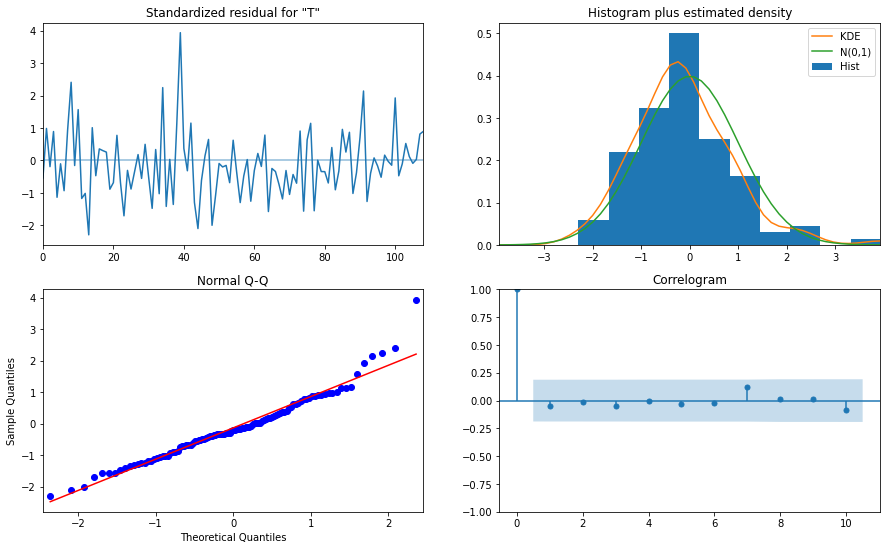

In [119]:
results.plot_diagnostics(figsize=(15, 9))
plt.show()

In [150]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-20 05:28:00'), dynamic=False)
pred_ci = pred.conf_int()

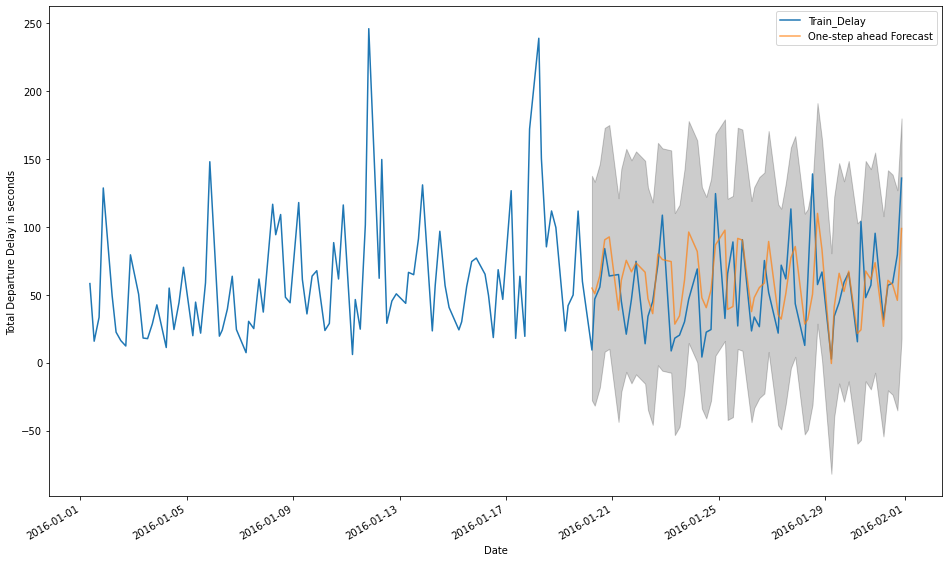

In [163]:
ax = dfGroupie['2016-01-01 06:44:00':].plot(label='observed', figsize=(16, 10))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Total Departure Delay in seconds')
plt.legend()

plt.show()

In [186]:
delay_forecasted = pred.predicted_mean
delay_truth = dfGroupie['2016-01-20 05:28:00':]
delay_truth = delay_truth.squeeze()

# Compute the mean square error
mse = ((delay_forecasted - delay_truth) ** 2).mean()

print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1093.83


In [190]:
math.sqrt(mse)

33.073120479652935

In [193]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2016-01-20 05:28:00'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

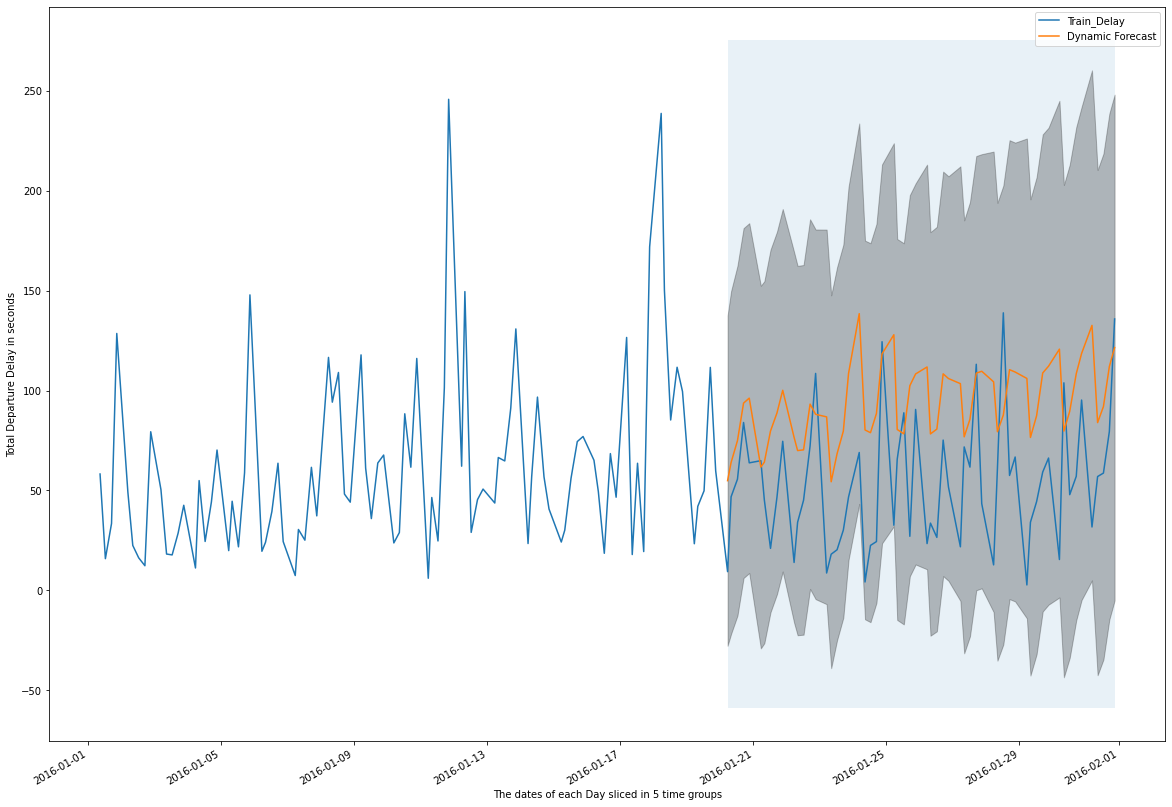

In [194]:
ax = dfGroupie['2016-01-01 06:44:00':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-01-20 05:28:00'), dfGroupie.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('The dates of each Day sliced in 5 time groups')
ax.set_ylabel('Total Departure Delay in seconds')

plt.legend()
plt.show()

In [196]:
# Extract the predicted and true values of our time series
delay_forecasted = pred_dynamic.predicted_mean
delay_truth = dfGroupie['2016-01-20 05:28:00':]
delay_truth = delay_truth.squeeze()

# Compute the mean square error
mse = ((delay_forecasted - delay_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2657.73


In [197]:
math.sqrt(mse)

51.55315253399847

In [200]:
(delay_forecasted - delay_truth).max()

105.31040925650709

# Conclusion